Importar librerias requeridas

In [1]:
import ee 
import geemap
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Autenticación con GEE y extracción de zona de estudio

In [2]:
ee.Authenticate()
ee.Initialize(project='ee-rimartinezs')

In [3]:
with open(os.path.join(os.getcwd(), '..', 'data', 'Localidad_Usme.geojson')) as geojson:
    data = json.load(geojson)

zona_estudio = ee.FeatureCollection(data)

Calculo del NDVI de la imagen con menos cobertura de nubes

In [ ]:
# Colección Sentinel 2
Sen2Collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(zona_estudio) \
    .filterDate('2023-01-01', '2023-12-31')\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)) \
    .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'])

# Recortar imágenes
def recortar(img):
    return img.clip(zona_estudio)

aoi_Sen2Collection = Sen2Collection.map(recortar)

# Identificar imágenes y calcular área cubierta
imagenes = aoi_Sen2Collection.toList(aoi_Sen2Collection.size())
area_total = zona_estudio.geometry().area().getInfo()

resultados = []

for i in range(aoi_Sen2Collection.size().getInfo()):
    img = ee.Image(imagenes.get(i))
    img_id = img.id().getInfo()  
    mascara_valida = img.select(0).mask().gt(0)
    pix_area = ee.Image.pixelArea().updateMask(mascara_valida)
    area_cubierta = pix_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=zona_estudio.geometry(),
        scale=10,
        maxPixels=1e10
    ).get('area').getInfo()
    porcentaje_cobertura = (area_cubierta / area_total) * 100 if area_total > 0 else 0
    resultados.append({'id': img_id, 'area_cubierta': area_cubierta, 'porcentaje': porcentaje_cobertura})

# Ordenar por porcentaje de cobertura descendente
resultados_ordenados = sorted(resultados, key=lambda x: x['porcentaje'], reverse=True)

# Mostrar resultados
for r in resultados_ordenados:
    print(f"Imagen: {r['id']}, Área cubierta: {r['area_cubierta']:.2f} m², Porcentaje: {r['porcentaje']:.2f}%")


Imagen: 20230128T152639_20230128T152835_T18NWK, Área cubierta: 207435705.10 m², Porcentaje: 96.11%
Imagen: 20230202T152641_20230202T152642_T18NWK, Área cubierta: 207435705.10 m², Porcentaje: 96.11%
Imagen: 20230207T152639_20230207T152901_T18NWK, Área cubierta: 207435705.10 m², Porcentaje: 96.11%
Imagen: 20230403T152641_20230403T152638_T18NWK, Área cubierta: 207435705.10 m², Porcentaje: 96.11%
Imagen: 20230518T152639_20230518T152642_T18NWK, Área cubierta: 207435705.10 m², Porcentaje: 96.11%
Imagen: 20230826T152639_20230826T153029_T18NWK, Área cubierta: 207435705.10 m², Porcentaje: 96.11%
Imagen: 20230503T152641_20230503T153004_T18NWK, Área cubierta: 207435705.10 m², Porcentaje: 96.11%
Imagen: 20230831T152641_20230831T152943_T18NWK, Área cubierta: 207435705.10 m², Porcentaje: 96.11%
Imagen: 20230826T152639_20230826T153029_T18NWL, Área cubierta: 64947578.19 m², Porcentaje: 30.09%
Imagen: 20230128T152639_20230128T152835_T18NWL, Área cubierta: 64947578.19 m², Porcentaje: 30.09%
Imagen: 2023

In [5]:
# Filtrar imágenes con más del 95% de cobertura
imagenes_filtradas = [r for r in resultados if r['porcentaje'] >= 95]
ids_filtradas = [r['id'] for r in imagenes_filtradas]

print("Imágenes con más del 95% de cobertura:")
for r in imagenes_filtradas:
    print(f"Imagen: {r['id']}, Porcentaje: {r['porcentaje']:.2f}%")


Imágenes con más del 95% de cobertura:
Imagen: 20230128T152639_20230128T152835_T18NWK, Porcentaje: 96.11%
Imagen: 20230202T152641_20230202T152642_T18NWK, Porcentaje: 96.11%
Imagen: 20230207T152639_20230207T152901_T18NWK, Porcentaje: 96.11%
Imagen: 20230403T152641_20230403T152638_T18NWK, Porcentaje: 96.11%
Imagen: 20230503T152641_20230503T153004_T18NWK, Porcentaje: 96.11%
Imagen: 20230518T152639_20230518T152642_T18NWK, Porcentaje: 96.11%
Imagen: 20230826T152639_20230826T153029_T18NWK, Porcentaje: 96.11%
Imagen: 20230831T152641_20230831T152943_T18NWK, Porcentaje: 96.11%


In [ ]:
# Obtener la lista de imágenes de la colección recortada
imagenes_ee = aoi_Sen2Collection.toList(aoi_Sen2Collection.size())

# Crear una lista de imágenes filtradas usando los índices de las imágenes con >95% cobertura
imagenes_filtradas_ee = [ee.Image(imagenes_ee.get(i)) for i, r in enumerate(resultados) if r['porcentaje'] >= 95]


Cantidad de imágenes con cobertura >95%: 8


In [7]:
Sen2_filtrado = ee.ImageCollection(imagenes_filtradas_ee)
print('Cantidad de imágenes con cobertura >95%:', Sen2_filtrado.size().getInfo())
Sen2_filtrado

Cantidad de imágenes con cobertura >95%: 8


K-means para estadisticas zonales

In [8]:
# Seleccion de la primera imagen de la colección filtrada
primera_img = ee.Image(Sen2_filtrado.first())

bandas = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']  

img_clasif = primera_img.select(bandas)

# Parámetros de K-means
num_clusters = 8
num_pixels = 5000
seed = 0

# Crear muestra de entrenamiento
training = img_clasif.sample(
    region=zona_estudio.geometry(),
    scale=10,
    numPixels=num_pixels,
    seed=seed,
    geometries=True
)

# Entrenar el clusterizador K-means
clusterer = ee.Clusterer.wekaKMeans(num_clusters, seed).train(training)
resultado = img_clasif.cluster(clusterer)



In [9]:
# Visualización
palette = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', 
    '#911eb4', '#46f0f0', '#f032e6', '#f58231'
]

Map = geemap.Map()
Map.centerObject(zona_estudio, 12)
Map.addLayer(primera_img, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Imagen original')
Map.addLayer(resultado, {'min': 0, 'max': num_clusters-1, 'palette': palette}, 'K-means (8 clases)')
Map.addLayer(zona_estudio, {}, 'Zona de estudio')
Map.addLayerControl()
Map

Map(center=[4.390019031052832, -74.14281202673868], controls=(WidgetControl(options=['position', 'transparent_…

In [10]:
imagenes = Sen2_filtrado.toList(Sen2_filtrado.size())
n_imagenes = Sen2_filtrado.size().getInfo()

In [11]:
Sen2_filtrado

In [ ]:
#Calcular NDVI y estadísticas por cluster
for i in range(n_imagenes):
    img = ee.Image(imagenes.get(i))
    img_id = img.id().getInfo()
    fecha = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd').getInfo()

    ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')
    ndvi_cluster = ndvi.addBands(resultado.rename('cluster'))

    stats = ndvi_cluster.reduceRegion(
        reducer=ee.Reducer.mean().group(groupField=1, groupName='cluster'),
        geometry=zona_estudio.geometry(),
        scale=10,
        maxPixels=1e13
    ).getInfo()

    for group in stats['groups']:
        resultados.append({
            'imagen_id': img_id,
            'date': fecha,
            'cluster': group['cluster'],
            'NDVI_mean': group['mean']
        })

df = pd.DataFrame(resultados)
df = df.rename(columns={'mean': 'NDVI_mean'})  
df['date'] = pd.to_datetime(df['date'])

Grafico NDVI en series de tiempo

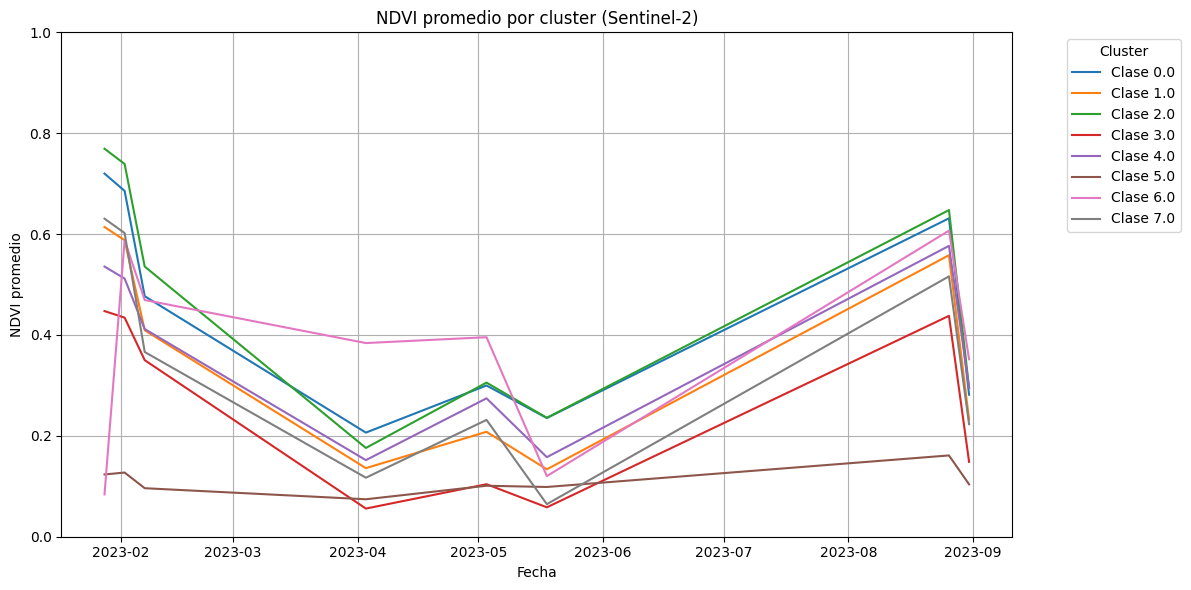

In [13]:
plt.figure(figsize=(12, 6))
for key, grp in df.groupby('cluster'):
    plt.plot(grp['date'], grp['NDVI_mean'], label=f'Clase {key}')
plt.title('NDVI promedio por cluster (Sentinel-2)')
plt.xlabel('Fecha')
plt.ylabel('NDVI promedio')
plt.ylim(0, 1)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()